# Stacking

## How does stacking work?

1) Generate a Meta-Model - from predictions of set of weak learners (using k-fold cv)

2) Train the Meta-Model with a final estimator (a ML model)


### Steps:

Level-0: use weak learners to generate training data for the meta-model. 'Stack' the prediction from each weak learners and that became the training set of the Meta Model

Level-1: Train the meta-model

### Code Example from Medium-Fernando López 

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

class Ensemble:
    def __init__(self):
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.k = 5

    def load_data(self):
        x, y = load_breast_cancer(return_X_y=True)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.3, random_state=23)
    
    def StackingClassifier(self):

        # Define weak learners
        weak_learners = [('dt', DecisionTreeClassifier()),
                        ('knn', KNeighborsClassifier()),
                        ('rf', RandomForestClassifier()),
                        ('gb', GradientBoostingClassifier()),
                        ('gn', GaussianNB())]
        
        # Finaler learner or meta model
        final_learner = LogisticRegression()

        train_meta_model = None
        test_meta_model = None

        # Start stacking
        for clf_id, clf in weak_learners:
            # Predictions for each classifier based on k-fold
            predictions_clf = self.k_fold_cross_validation(clf)
            
            # Predictions for test set for each classifier based on train of level 0
            test_predictions_clf = self.train_level_0(clf)
            
            # Stack predictions which will form 
            # the inputa data for the data model
            if isinstance(train_meta_model, np.ndarray):
                train_meta_model = np.vstack((train_meta_model, predictions_clf))
            else:
                train_meta_model = predictions_clf

            # Stack predictions from test set
            # which will form test data for meta model
            if isinstance(test_meta_model, np.ndarray):
                test_meta_model = np.vstack((test_meta_model, test_predictions_clf))
            else:
                test_meta_model = test_predictions_clf
        
        # Transpose train_meta_model
        train_meta_model = train_meta_model.T

        # Transpose test_meta_model
        test_meta_model = test_meta_model.T
        
        # Training level 1
        self.train_level_1(final_learner, train_meta_model, test_meta_model)


    def k_fold_cross_validation(self, clf):
        
        predictions_clf = None

        # Number of samples per fold
        batch_size = int(len(self.x_train) / self.k)

        # Stars k-fold cross validation
        for fold in range(self.k):

            # Settings for each batch_size
            if fold == (self.k - 1):
                test = self.x_train[(batch_size * fold):, :]
                batch_start = batch_size * fold
                batch_finish = self.x_train.shape[0]
            else:
                test = self.x_train[(batch_size * fold): (batch_size * (fold + 1)), :]
                batch_start = batch_size * fold
                batch_finish = batch_size * (fold + 1)
            
            # test & training samples for each fold iteration
            fold_x_test = self.x_train[batch_start:batch_finish, :]
            fold_x_train = self.x_train[[index for index in range(self.x_train.shape[0]) if index not in range(batch_start, batch_finish)], :]

            # test & training targets for each fold iteration
            fold_y_test = self.y_train[batch_start:batch_finish]
            fold_y_train = self.y_train[[index for index in range(self.x_train.shape[0]) if index not in range(batch_start, batch_finish)]]

            # Fit current classifier
            clf.fit(fold_x_train, fold_y_train)
            fold_y_pred = clf.predict(fold_x_test)

            # Store predictions for each fold_x_test
            if isinstance(predictions_clf, np.ndarray):
                predictions_clf = np.concatenate((predictions_clf, fold_y_pred))
            else:
                predictions_clf = fold_y_pred

        return predictions_clf

    def train_level_0(self, clf):
        # Train in full real training set
        clf.fit(self.x_train, self.y_train)
        # Get predictions from full real test set
        y_pred = clf.predict(self.x_test)
        
        return y_pred

    def train_level_1(self, final_learner, train_meta_model, test_meta_model):
        # Train is carried out with final learner or meta model
        final_learner.fit(train_meta_model, self.y_train)
        # Getting train and test accuracies from meta_model
        print(f"Train accuracy: {final_learner.score(train_meta_model,  self.y_train)}")
        print(f"Test accuracy: {final_learner.score(test_meta_model, self.y_test)}")
        

if __name__ == "__main__":
    ensemble = Ensemble()
    ensemble.load_data()
    ensemble.StackingClassifier()

Train accuracy: 0.9522613065326633
Test accuracy: 0.9707602339181286


### Code Example from DataWhale

In [6]:
from sklearn import datasets
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
RANDOM_SEED = 42
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()
# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], # 第一层分类器
meta_classifier=lr, # 第二层分类器
random_state=RANDOM_SEED)
print('3-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'NaiveBayes','StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [NaiveBayes]
Accuracy: 0.93 (+/- 0.02) [StackingClassifier]


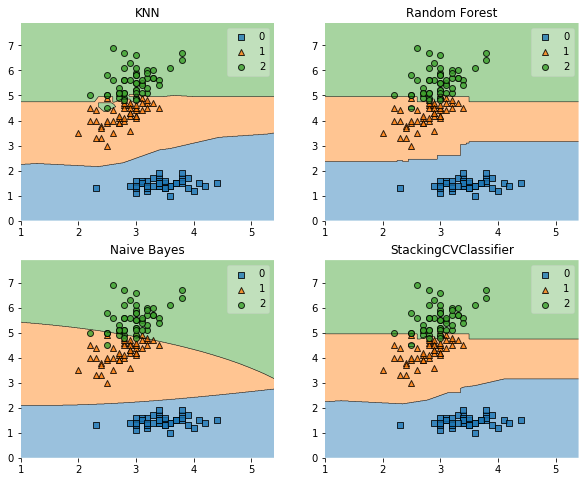

In [9]:
#Decision Boundary
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
import matplotlib.pyplot as plt

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip([clf1, clf2, clf3, sclf],['KNN','Random Forest','Naive Bayes','StackingCVClassifier'],itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

In [12]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
use_probas=True, #
meta_classifier=lr,
random_state=42)
print('3-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3, sclf],['KNN','Random Forest','Naive Bayes','StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"% (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [StackingClassifier]


References:
    
Ensemble Learning: Stacking, Blending & Voting: https://towardsdatascience.com/ensemble-learning-stacking-blending-voting-b37737c4f483

Datawhale: https://github.com/datawhalechina/team-learning-data-mining/tree/master/EnsembleLearning